In [11]:
# Setup and Download
!pip install -q kaggle
import os
from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

print("Downloading NEU Dataset...")
!kaggle datasets download -d kaustubhdikshit/neu-surface-defect-database
!unzip -q neu-surface-defect-database.zip -d neu_data
print("Dataset downloaded and extracted!")

Dataset URL: https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database
License(s): unknown
neu-surface-defect-database.zip: Skipping, found more recently modified local copy (use --force to force download)
replace neu_data/NEU-DET/train/annotations/crazing_1.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Dataset downloaded and extracted!


In [12]:
# Data Preprocessing
import tensorflow as tf

IMG_SIZE = (64, 64) # Constraint for TinyML (64 x 64 IMG)
BATCH_SIZE = 32
DATA_DIR = 'neu_data/NEU-DET/train/images'

print("Loading datasets...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Loading datasets...
Found 1440 files belonging to 6 classes.
Using 1152 files for training.
Found 1440 files belonging to 6 classes.
Using 288 files for validation.


In [13]:
# Model Architecture
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(64, 64, 3),
    alpha=0.35,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1), # Normalizing pixels to [-1, 1]
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(6, activation='softmax') # 6 defect classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Training the Tiny Model...")
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

/tmp/ipython-input-3345284443.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Training the Tiny Model...
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.5230 - loss: 1.2862 - val_accuracy: 0.9514 - val_loss: 0.2599
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9439 - loss: 0.2174 - val_accuracy: 0.9618 - val_loss: 0.1655
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9796 - loss: 0.1255 - val_accuracy: 0.9653 - val_loss: 0.1300
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9774 - loss: 0.1109 - val_accuracy: 0.9757 - val_loss: 0.1082
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9870 - loss: 0.0780 - val_accuracy: 0.9757 - val_loss: 0.0909
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9934 - loss: 0.0650 - val_accuracy: 0.9792 - val_loss: 0.0816
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9953 - loss: 0.0574 - val_accuracy: 0.9792 - val_loss: 0.0757
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9980 - loss: 0.04

In [9]:
# Quantization
def representative_dataset():
    for images, labels in train_dataset.take(1):
        for i in range(10):
            yield [tf.expand_dims(images[i], axis=0)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

with open('tiny_model_quantized.tflite', 'wb') as f:
    f.write(tflite_quant_model)

print(f"Success! Your Quantized Model Size is: {len(tflite_quant_model) / 1024:.2f} KB")

Saved artifact at '/tmp/tmp3vix1v2z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_313')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137822236537296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236540752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236539216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236536528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236535952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236540176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236540560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236536144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236539792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236535760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137822236533

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Success! Your Quantized Model Size is: 610.15 KB


Extracting predictions from the validation dataset...

--- 1. Classification Report ---
                 precision    recall  f1-score   support

        crazing       0.98      0.98      0.98        41
      inclusion       0.96      1.00      0.98        53
        patches       1.00      0.98      0.99        53
 pitted_surface       1.00      0.96      0.98        47
rolled-in_scale       0.96      1.00      0.98        45
      scratches       1.00      0.98      0.99        49

       accuracy                           0.98       288
      macro avg       0.98      0.98      0.98       288
   weighted avg       0.98      0.98      0.98       288


--- 2. Confusion Matrix ---


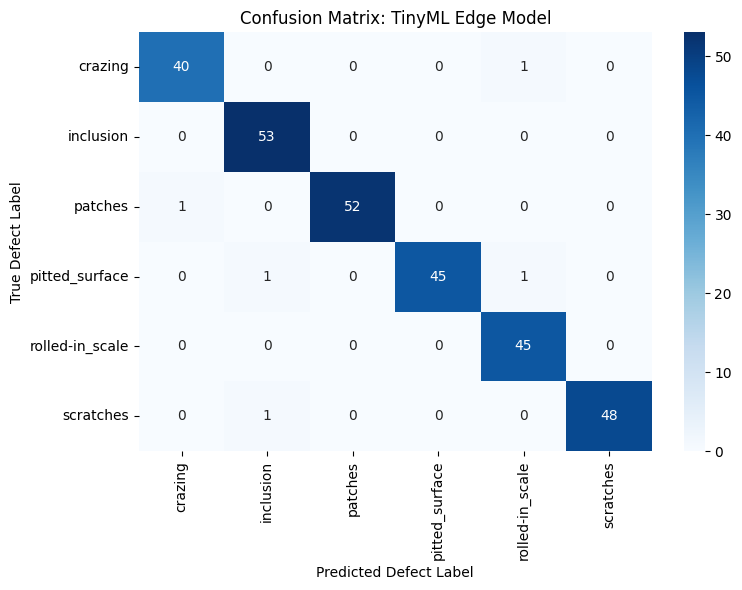


--- 3. Confidence Score Distribution ---


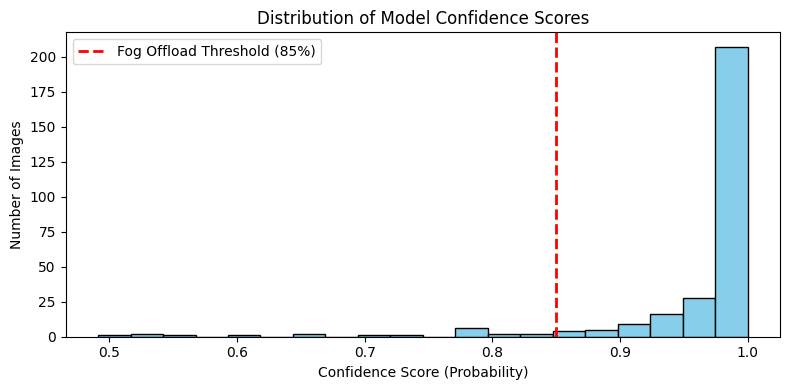

In [14]:
# Model Evaluation & Metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("Extracting predictions from the validation dataset...")
y_true = []
y_pred = []
confidences = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1)) # The predicted class
    confidences.extend(np.max(preds, axis=1)) # The confidence score

y_true = np.array(y_true)
y_pred = np.array(y_pred)
confidences = np.array(confidences)

class_names = val_dataset.class_names

# Classification Report (F1-Score, Precision, Recall)
print("\n--- 1. Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix Plot
print("\n--- 2. Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: TinyML Edge Model')
plt.ylabel('True Defect Label')
plt.xlabel('Predicted Defect Label')
plt.tight_layout()
plt.show()

# Confidence Score Distribution Plot (For Fog Offloading)
print("\n--- 3. Confidence Score Distribution ---")
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.axvline(x=0.85, color='red', linestyle='dashed', linewidth=2,
            label='Fog Offload Threshold (85%)')
plt.title('Distribution of Model Confidence Scores')
plt.xlabel('Confidence Score (Probability)')
plt.ylabel('Number of Images')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
# Simulation Trace
import pandas as pd
import numpy as np

results = []
image_id = 0

print("Generating simulation trace file...")
for images, labels in val_dataset.take(10):
    predictions = model.predict(images, verbose=0)

    for i in range(len(predictions)):
        confidence = np.max(predictions[i])

        # If confidence is below 85%, send to the Fog layer.
        decision = "Local" if confidence >= 0.85 else "Fog"

        results.append({
            "Image_ID": f"Img_{image_id:04d}",
            "Image_Size_KB": np.random.randint(40, 60), # Simulated file size
            "Confidence": round(float(confidence), 3),
            "Decision": decision,
            "Latency_ms": 15 if decision == "Local" else 150 # Simulated execution time
        })
        image_id += 1

trace_df = pd.DataFrame(results)
trace_df.to_csv("simulation_trace.csv", index=False)

print("\nTrace file generated successfully")
print(trace_df.head())

Generating simulation trace file...

Trace file generated successfully
   Image_ID  Image_Size_KB  Confidence Decision  Latency_ms
0  Img_0000             55       0.999    Local          15
1  Img_0001             41       0.654      Fog         150
2  Img_0002             47       0.963    Local          15
3  Img_0003             52       0.997    Local          15
4  Img_0004             54       0.999    Local          15
